In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

# Replace with whatever model import(s) you're using
from xgboost import XGBClassifier


%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv("data/SBAnational.csv")

C:\Users\dgump\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>

In [4]:
pd.options.display.max_rows = 999
data["ApprovalFY"].value_counts(dropna=False)

data.loc[data["ApprovalFY"] == "1976A", "ApprovalFY"] = "1976"
data["ApprovalFY"] = data["ApprovalFY"].astype(int)
data["ApprovalFY"].value_counts(dropna=False)

2005    77525
2006    76040
2007    71876
2004    68290
2003    58193
1995    45758
2002    44391
1996    40112
2008    39540
1997    37748
2000    37381
1999    37363
2001    37350
1998    36016
1994    31598
1993    23305
1992    20885
2009    19126
2010    16848
1991    15666
1990    14859
1989    13248
2011    12608
2012     5997
2013     2458
1987     2218
1986     2118
1984     2022
1985     1944
1988     1898
1983     1684
1982      719
1981      630
1980      477
1979      352
2014      268
1978      242
1977      137
1976       84
1973       52
1974       42
1975       30
1972       27
1971       20
1970        8
1969        4
1968        2
1967        2
1966        1
1965        1
1962        1
Name: ApprovalFY, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
# first two digits are industry code. Extracted anc onverted to int
# code 0 may need investigating

data["NAICS"].astype(str).str[0:2].value_counts(dropna=False)

data["twoDigNAICS"] = data["NAICS"].astype(str).str[0:2]
data["twoDigNAICS"] = data["twoDigNAICS"].astype(int)
data["twoDigNAICS"].value_counts(dropna=False)

0     201948
44     84737
81     72618
54     68170
72     67600
23     66646
62     55366
42     48743
45     42514
33     38284
56     32685
48     20310
32     17936
71     14640
53     13632
31     11809
51     11379
52      9496
11      9005
61      6425
49      2221
21      1851
22       663
55       257
92       229
Name: twoDigNAICS, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
# 0 and 1 indicate not a franchise. Created binary is_franchise column
data["FranchiseCode"].value_counts(dropna=False).index.sort_values()
data.loc[data["FranchiseCode"] > 1, "is_franchise"] = 1
data.loc[data["FranchiseCode"] <= 1, "is_franchise"] = 0
data["is_franchise"].value_counts(dropna=False)

0.0    847389
1.0     51775
Name: is_franchise, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
# similar to above. Created binary variable for having revolving line of credit

# some nonsense in here
data["RevLineCr"].value_counts(dropna=False)

revCR_map = {
    "N": 0,
    "0": 0,
    "Y": 1,
    "T": 1,  # T for true? maybe
}
data["RevLineCr"] = data["RevLineCr"].map(revCR_map)
# data["RevLineCr"] = data["RevLineCr"].astype(int, errors="ignore")
data["RevLineCr"].value_counts(dropna=False)

0.0    677890
1.0    216681
NaN      4593
Name: RevLineCr, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
# clean state columns. Filled with BankState. May have biased new feature bank_out_of_state
# was only 14, so not that big of a deal
data["State"].isna().sum()
data[data["State"].isna()]

data["State"] = data["State"].fillna(data["BankState"])
data["State"].isna().sum()

# 1 left from 1981, looks like nothing we want
data[data["State"].isna()]

data = data.dropna(subset=["State"])
cleaned_States = list(data["State"].value_counts().sort_index().index)
#cleaned_States


<IPython.core.display.Javascript object>

In [9]:
# clean Bank State
# Handled weird out of country banks by selecting based on the State column
# definite bias here. Out of country banks may follow a trend
data["BankState"].value_counts().sort_index()

# keep rows where the BankState value appears more than 100 times. Want to match State column
valid_states = list(data["State"].value_counts().index)
bankState_valid = data["BankState"].isin(valid_states)
# only going to lose 1700 rows. Drop em.
cleaned_bankStates = list(
    data.loc[bankState_valid, "BankState"].value_counts().sort_index().index
)

data = data.loc[bankState_valid]

<IPython.core.display.Javascript object>

In [10]:
# made binary column bank_out_of_state

data["bank_out_of_state"] = data["State"] == data["BankState"]
data["bank_out_of_state"] = data["bank_out_of_state"].astype(int)
data["bank_out_of_state"].value_counts(dropna=False)

1    473953
0    423481
Name: bank_out_of_state, dtype: int64

<IPython.core.display.Javascript object>

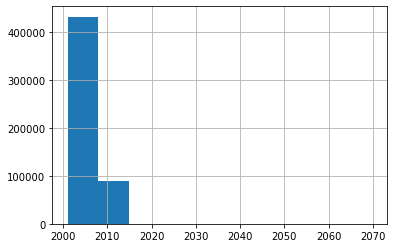

<IPython.core.display.Javascript object>

In [11]:
# Approval Date. No NA's originally
# ~some are in the future! Handle this. Maybe hit 2 instead of 1?~
# pd_to_datetime() behaves starngely across decades, or may have been a simple typo
# 2076 or whatever is definitely outside of our consideration either way
data["ApprovalDate_datetime"] = pd.to_datetime(data["ApprovalDate"])
data.loc[data["ApprovalDate_datetime"].dt.year > 2000, "ApprovalDate_datetime"].hist()

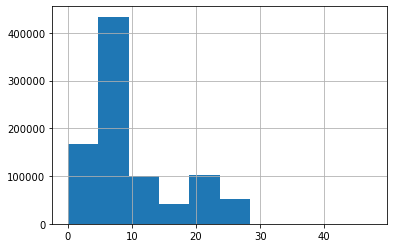

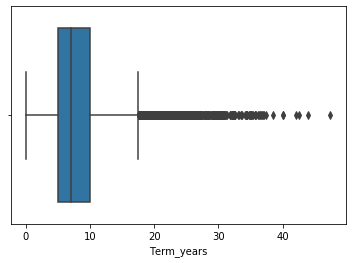

count    897434.000000
mean        110.777526
std          78.863169
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

<IPython.core.display.Javascript object>

In [12]:
# clean term column. IN months, convert to years
# appears to be some skew.
data["Term"].isna().sum()
data["Term_years"] = data["Term"] / 12
data["Term_years"].hist()
plt.show()
sns.boxplot(data["Term_years"])
plt.show()
data["Term"].describe()

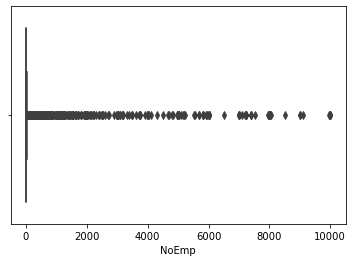

count    897434.000000
mean         11.405530
std          74.171788
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

<IPython.core.display.Javascript object>

In [13]:
# clean noemp columns
# lots of skew to consider
data["NoEmp"].isna().sum()
data["NoEmp"].value_counts()
sns.boxplot(data["NoEmp"])
plt.show()
data["NoEmp"].describe()

In [14]:
# clean NewExist column. 1 is existing, 2 is new. Handle na's and 0's
# note: some approval dates are in the future!
pd.options.display.max_columns = 999
data["NewExist"].isna().sum
data["NewExist"].value_counts(dropna=False)

data.loc[data["NewExist"].isna(), "ApprovalDate_datetime"].value_counts().sort_index()
data.loc[data["NewExist"].isna(), "bank_out_of_state"].value_counts()
data.loc[data["NewExist"].isna(), "ApprovalDate_datetime"].describe()
# some weirdness with the na's. All but one are from dec-2019 through around 2010.
# just going on a hunch and filling these missing values with 1: an existing business
NewExist_map = {1: 0, 2: 1, 0: 1, np.nan: 1}

data["NewExist"] = data["NewExist"].map(NewExist_map)
data["NewExist"].value_counts()

0    643591
1    253843
Name: NewExist, dtype: int64

<IPython.core.display.Javascript object>

0.0    470632
NaN    321469
1.0    105333
Name: UrbanRural_cleaned, dtype: int64

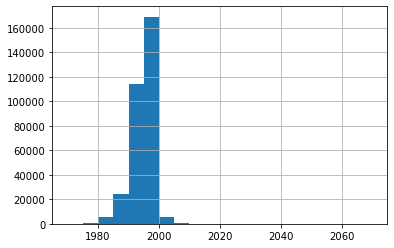

<IPython.core.display.Javascript object>

In [15]:
# clean urban/rural column. 1: urban, 2: rural, 0:undefined
data["UrbanRural"].value_counts()

# investigate na's for patterns, but will definitely remap to 0,1
data.loc[data["UrbanRural"] == 0, "ApprovalDate_datetime"].describe()
# looks lijke undefined (0's) are from mid-late 90's
# clue that future values might need to be 19 not 20
data.loc[data["UrbanRural"] == 0, "ApprovalDate_datetime"].hist(bins=20)
data["UrbanRural"].value_counts()

UrbanRural_map = {1: 0, 2: 1, 0: np.nan}

data["UrbanRural_cleaned"] = data["UrbanRural"].map(UrbanRural_map)
data["UrbanRural_cleaned"].value_counts(dropna=False)

In [16]:
# clean LowDoc. Lot's of Na's
# y = yes, n = no
data["LowDoc"].isna().sum()
data["LowDoc"].value_counts(dropna=False)
# more nonsense, awesome
LowDoc_map = {
    "N": 0,
    "Y": 1,
}
data['LowDoc'] = data["LowDoc"].map(LowDoc_map, na_action="ignore")
data['LowDoc'].value_counts(dropna=False)


0.0    781263
1.0    110166
NaN      6005
Name: LowDoc, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
# getting into dates, so I went ahead and selected my years.
# This will cut down on NA's and errant values

data = data.loc[
    data["ApprovalDate_datetime"].dt.year < 2020,
]
data = data.loc[data["ApprovalDate_datetime"].dt.year > 2000]

<IPython.core.display.Javascript object>

In [18]:
# Disbursement Date
# Converted to datetime. Extrcated year.
# converted month to cyclical feature with a unit circle transform
# may want to keep this in mind for scaling
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

data["DisbursementDate"].isna().sum()
data.loc[data["DisbursementDate"].isna()]
data["DisbursementDate"] = data["DisbursementDate"].fillna(data["ApprovalDate"])

data["Disbr_datetime"] = pd.to_datetime(data["DisbursementDate"])

# cuts dout about 300k rows
data = data.loc[data["Disbr_datetime"].dt.year.isin(np.arange(2000, 2020, 1))]
data["Disbr_datetime"].dt.year.describe()
# # note the 2069 jumping out again. Just going to ignore it,
# # because it is from a time we don't care about
data["Disbr_year"] = data["Disbr_datetime"].dt.year
data["Disbr_month"] = data["Disbr_datetime"].dt.month - 1
data["Disbr_Month_sin"] = np.sin((data["Disbr_month"]) * (2.0 * np.pi / 12))
data["Disbr_Month_cos"] = np.cos((data["Disbr_month"]) * (2.0 * np.pi / 12))

<IPython.core.display.Javascript object>

In [19]:
# make a feature identifying if SBA approval was given before or after loan disbursed

data["time_to_disbr"] = data["Disbr_datetime"] - data["ApprovalDate_datetime"]

sba_pre_approved = data["time_to_disbr"] > np.timedelta64(0, "D")
sba_pre_approved.value_counts(dropna=False)
data.loc[sba_pre_approved, "sba_pre_approv"] = 1
data.loc[~sba_pre_approved, "sba_pre_approv"] = 0
data["sba_pre_approv"].value_counts(dropna=False)

1.0    505565
0.0     17017
Name: sba_pre_approv, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
data["DisbursementGross"].isna().sum()
data["DisbursementGross"] = data["DisbursementGross"].str.replace("$", "")
data["DisbursementGross"] = data["DisbursementGross"].str.replace(",", "")
data["DisbursementGross"] = data["DisbursementGross"].astype(float)

<IPython.core.display.Javascript object>

In [21]:
data["BalanceGross"].isna().sum()
# data["BalanceGross"].value_counts()
data["BalanceGross"] = data["BalanceGross"].str.replace("$", "")
data["BalanceGross"] = data["BalanceGross"].str.replace(",", "")
data["BalanceGross"] = data["BalanceGross"].astype(float)

<IPython.core.display.Javascript object>

In [22]:
# clean ChgOffPrinGr

data["ChgOffPrinGr"].isna().sum()
data["ChgOffPrinGr"].value_counts()
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].str.replace("$", "")
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].str.replace(",", "")
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].astype(float)

<IPython.core.display.Javascript object>

In [23]:
# cleaned grappv
data["GrAppv"].isna().sum()
data["GrAppv"] = data["GrAppv"].str.replace("$", "")
data["GrAppv"] = data["GrAppv"].str.replace(",", "")
data["GrAppv"] = data["GrAppv"].astype(float)

<IPython.core.display.Javascript object>

In [24]:
# clean SBA_Appv

data["SBA_Appv"].isna().sum()
data["SBA_Appv"].value_counts()

data["SBA_Appv"] = data["SBA_Appv"].str.replace("$", "")
data["SBA_Appv"] = data["SBA_Appv"].str.replace(",", "")
data["SBA_Appv"] = data["SBA_Appv"].astype(float)

<IPython.core.display.Javascript object>

In [25]:
data["percent_SBA"] = data["SBA_Appv"] / data["GrAppv"]
data["percent_SBA"].describe()

count    522582.000000
mean          0.641991
std           0.173797
min           0.050000
25%           0.500000
50%           0.500000
75%           0.850000
max           1.000000
Name: percent_SBA, dtype: float64

<IPython.core.display.Javascript object>

In [26]:
data = data.loc[data["MIS_Status"].notna()]
MIS_Status_map = {"P I F": 0, "CHGOFF": 1, 0: 0, 1: 1}

data["MIS_Status"] = data["MIS_Status"].map(MIS_Status_map, na_action="ignore")
data["MIS_Status"].value_counts(dropna=False)

0    390973
1    129981
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
banks = data["Bank"].value_counts()

big_banks = banks.loc[banks.values >= 1000].index.to_list()

med_banks = banks.loc[banks.values >= 100]
med_banks = med_banks.loc[med_banks.values < 1000]
med_banks = med_banks.index.to_list()

small_banks = banks.loc[banks.values < 100].index.to_list()

data.loc[data["Bank"].isin(small_banks), "bank_size"] = 0
data.loc[data["Bank"].isin(med_banks), "bank_size"] = 1
data.loc[data["Bank"].isin(big_banks), "bank_size"] = 2


<IPython.core.display.Javascript object>

In [28]:
# data["Approval_Year"] = data["ApprovalDate_datetime"].dt.year
# ApprvFY moe informative, but want the months
data["Approval_Month"] = data["ApprovalDate_datetime"].dt.month - 1
data["Appv_Month_sin"] = np.sin((data["Approval_Month"]) * (2.0 * np.pi / 12))
data["Appv_Month_cos"] = np.cos((data["Approval_Month"]) * (2.0 * np.pi / 12))

<IPython.core.display.Javascript object>

In [29]:
data = data.dropna(subset=["RevLineCr", "LowDoc", "UrbanRural_cleaned"])

<IPython.core.display.Javascript object>

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510160 entries, 12 to 894832
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   LoanNr_ChkDgt          510160 non-null  int64          
 1   Name                   510153 non-null  object         
 2   City                   510160 non-null  object         
 3   State                  510160 non-null  object         
 4   Zip                    510160 non-null  int64          
 5   Bank                   510160 non-null  object         
 6   BankState              510160 non-null  object         
 7   NAICS                  510160 non-null  int64          
 8   ApprovalDate           510160 non-null  object         
 9   ApprovalFY             510160 non-null  int32          
 10  Term                   510160 non-null  int64          
 11  NoEmp                  510160 non-null  int64          
 12  NewExist               510160

<IPython.core.display.Javascript object>

In [31]:
trash_cols = [
    "LoanNr_ChkDgt",
    # "Name",
    # "City",
    # 'Bank State' expect colinearity
    # "Zip",  # might be useful, but State should be good enough
    "FranchiseCode",  # engineered to is_franchise
    "NAICS",
    "Term",
    #"CreateJob",
    #"RetainedJob",
    "ChgOffDate",
    "DisbursementDate",
    "ChgOffPrinGr",  # if this has a value, will give away target
    "ApprovalDate",
    #"Bank",
    "BalanceGross",  # redundant with MIS_Status
    "time_to_disbr",  # intermediate variable
    "SBA_Appv",  # engineered into percentage sba approved
    "UrbanRural",  # cleaned into new column
    "GrAppv",  # redundant to Disbursement gross
    "ApprovalDate_datetime",
    "Approval_Month",  # intermediate
    "Disbr_month",  # intermediate
    "Disbr_datetime",  # intermediate
]

data = data.drop(columns=trash_cols)


<IPython.core.display.Javascript object>

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510160 entries, 12 to 894832
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                510153 non-null  object 
 1   City                510160 non-null  object 
 2   State               510160 non-null  object 
 3   Zip                 510160 non-null  int64  
 4   Bank                510160 non-null  object 
 5   BankState           510160 non-null  object 
 6   ApprovalFY          510160 non-null  int32  
 7   NoEmp               510160 non-null  int64  
 8   NewExist            510160 non-null  int64  
 9   CreateJob           510160 non-null  int64  
 10  RetainedJob         510160 non-null  int64  
 11  RevLineCr           510160 non-null  float64
 12  LowDoc              510160 non-null  float64
 13  DisbursementGross   510160 non-null  float64
 14  MIS_Status          510160 non-null  int64  
 15  twoDigNAICS         510160 non-nu

<IPython.core.display.Javascript object>

In [33]:
data.to_csv("data/SBA_clnd.csv", index=False)

<IPython.core.display.Javascript object>

In [34]:
loans = pd.read_csv("data/SBA_clnd.csv")

<IPython.core.display.Javascript object>

In [35]:
loans.head()

,Name,City,State,Zip,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,2006,2,1,0,0,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,2006,7,0,0,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,2006,18,1,5,23,1.0,0.0,438541.0,0,61,0.0,0,6.916667,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,2006,4,0,0,4,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,2006,3,0,0,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [39]:
loans.loc[loans["Bank"] == "CITIBANK, N.A.", "BankState"].value_counts()

SD    2880
NY     730
CA     461
FL     380
TX     113
IL      26
DC       2
NV       1
NJ       1
Name: BankState, dtype: int64

<IPython.core.display.Javascript object>